In [1]:
%pylab inline
import os,sys,pickle
from scipy.stats import percentileofscore, chi2
from scipy.linalg import sqrtm
from scipy.interpolate import interp1d
from scipy.special import loggamma
from scipy.optimize import minimize
import emcee # only needed for step 8

Populating the interactive namespace from numpy and matplotlib


# Odd-Parity Nseries 4PCF Analysis
This notebook contains the main analysis routines used in Philcox (2022) to probe parity-violation in the isotropic connected 4-point correlation function (4PCF) of the Nseries CMASS mocks. For questions, email [Oliver Philcox](mailto:ohep2@cantab.ac.uk).

In [2]:
# Data directories (containing pre-computed BOSS data and Patchy simulations)
data_dir = '/home/ophilcox/Parity-Odd-4PCF/data/'
nseries_dir = '/home/ophilcox/Parity-Odd-4PCF/data_nseries/'

# Output plotting directory
plot_dir = '/home/ophilcox/Parity-Odd-4PCF/figs_nseries/'
if not os.path.exists(plot_dir): os.makedirs(plot_dir)

# Binning parameters (minimum/maximum side length, number of radial bins, max ell used in analysis)
R_min = 20 
R_max = 160 
n_r = 10
LMAX = 4

# Whether to normalize overall amplitudes
normalize_amp = False

# 1) Load 4PCFs
- These are computed with the [*encore*](https://github.com/oliverphilcox/encore) code of [Philcox et al. 2021](https://arxiv.org/abs/2105.08722)
- We use 10 linearly-space radial bins in the range [20, 160] $h^{-1}\mathrm{Mpc}$
- All multiplets (of odd- and even-parity) are computed up to $\ell_\mathrm{max} = 5$, with $\ell_i=5$ multiplets only being used for edge-correction.
- Here we consider only bins with $\ell_i\leq 4$, and ensure that all bin centers are separated by at least $\Delta r$ to avoid any vanishingly small separations.
- We analyze both the BOSS data, in the CMASS NGC and SGC regions, as well as 2048 MultiDark-Patchy mocks, cut to the Nseries window function.
- Note that the quantities loaded below are the *imaginary* parts of the 4PCF multiplets (if $\ell_1+\ell_2+\ell_3$ is odd).

In [3]:
binner = lambda bins: (0.5+bins)*(R_max-R_min)/n_r+R_min

### First Load Patchy data
with np.load(data_dir+'all_nseries-patchy2048_fourpcf.npz') as d:
    # Full 4PCF measurements
    fourpcf=d['fourpcf']
    # Disconnected 4PCF measurements
    fourpcfdisc = d['fourpcfdisc']
    # {r1, r2, r3}
    radii=d['radii']
    # {bin-index 1, bin-index 2, bin-index 3}
    bins=d['bins']
    # {ell-1, ell-2, ell-3}
    ells=d['ells']

n_radial = len(bins[0])
n_mult = len(ells[0])

### Now load the Nseries data

def load_nseries(mock_index,return_all=False,discon=False):
    """Load precomputed 4PCFs from the Nseries mocks."""
    if not discon:
        infile = nseries_dir+'nseries%s.zeta_4pcf.txt'%mock_index
    else:
        infile = nseries_dir+'nseries%s.zeta_discon_4pcf.txt'%mock_index
    bins1,bins2,bins3 = np.asarray(np.loadtxt(infile,skiprows=3,max_rows=3),dtype=int)
    ell1,ell2,ell3 = np.asarray(np.loadtxt(infile,skiprows=9)[:,:3],dtype=int).T
    fourpcf_nseries = np.loadtxt(infile,skiprows=9)[:,3:]
    r1_4pcf = binner(bins1)
    r2_4pcf = binner(bins2)
    r3_4pcf = binner(bins3)  
    if return_all:
        return [r1_4pcf,r2_4pcf,r3_4pcf],[bins1,bins2,bins3],[ell1,ell2,ell3],fourpcf_nseries
    else:
        return fourpcf_nseries

# Load the Nseries data
fourpcf_nseries, fourpcfdisc_nseries = [], []
for i in range(1,85):
    this_fourpcf_nseries = load_nseries(i)
    this_fourpcfd_nseries = load_nseries(i,discon=True)
    fourpcf_nseries.append(this_fourpcf_nseries)
    fourpcfdisc_nseries.append(this_fourpcfd_nseries)
fourpcfdisc_nseries = np.asarray(fourpcfdisc_nseries)
fourpcf_nseries = np.asarray(fourpcf_nseries)

n_mocks = len(fourpcf)
n_nseries = len(fourpcf_nseries)

print("N_mocks: %d"%n_mocks)
print("N_Nseries: %d"%n_nseries)
print("N_Lambda: %d"%n_mult)
print("N_radial: %d"%n_radial)

N_mocks: 2048
N_Nseries: 84
N_Lambda: 111
N_radial: 120


### (Optionally) Load Gaussian Theory Model
- We may optionally normalize the data by a realization-dependent amplitude, obtained by fitting the (even-parity) disconnected 4PCF to a physical Gaussian model.
- This will reduce the impact of an overall normalization difference between the BOSS data and Patchy simulations.

In [4]:
if normalize_amp:

    from scipy.interpolate import interp1d
    from scipy.special import spherical_jn
    from scipy.integrate import simps
    from sympy.physics.wigner import wigner_3j
    from scipy.special import sici

    ## Define bin-integrated Bessel functions. These are Integral[r^2 j_ell(kr)]/Integral[r^2] which are analytic.
    ## sici[0] is the Sine integral.
    ## ell>5 can be easily implemented also if needed

    from classy import Class
    Omega_m = 0.31
    omega_b = 0.022
    h = 0.676
    sigma_8 = 0.8
    n_s = 0.96
    M_nu = 0.06
    z_pk = 0.57
    cosmo = Class()
    cosmo.set({'omega_cdm':(Omega_m*h**2.-omega_b-0.00064),'omega_b':omega_b,'h':h,'sigma8':sigma_8,'n_s':n_s,
               'N_ncdm':1,'m_ncdm':M_nu,'z_pk':z_pk,'output':'mPk','non linear':'false'})
    cosmo.compute()

    b1_fid = 2.0
    f_fid = cosmo.scale_independent_growth_factor_f(z_pk)
    k = np.logspace(-4,1,1000)
    pk_lin = np.asarray([cosmo.pk_lin(kk*h,z_pk)*h**3. for kk in k])
    Pk_mult = np.asarray([(b1_fid**2+2*b1_fid*f_fid/3+f_fid**2./5.),4./21*b1_fid*(7*b1_fid+3.*f_fid),8.*f_fid**2./35.])[:,None]*pk_lin[None,:]

    def integ_bessel(ell,bin1):
        r_min = bin1*(R_max-R_min)/n_r+R_min
        r_max = (bin1+1.)*(R_max-R_min)/n_r+R_min
        if ell==0:
            tmp1 = (-k*r_max*np.cos(k*r_max)+np.sin(k*r_max))/k**3. 
            tmp2 = (-k*r_min*np.cos(k*r_min)+np.sin(k*r_min))/k**3.
        elif ell==1:
            tmp1 = -2.*np.cos(k*r_max)/k**3. - r_max*np.sin(k*r_max)/k**2.
            tmp2 = -2.*np.cos(k*r_min)/k**3. - r_min*np.sin(k*r_min)/k**2.
        elif ell==2:
            tmp1 = (r_max*np.cos(k*r_max))/k**2 - (4*np.sin(k*r_max))/k**3 + (3*sici(k*r_max)[0])/k**3
            tmp2 = (r_min*np.cos(k*r_min))/k**2 - (4*np.sin(k*r_min))/k**3 + (3*sici(k*r_min)[0])/k**3
        elif ell==3:
            tmp1 = (7.*np.cos(k*r_max))/k**3 - (15.*np.sin(k*r_max))/(k**4*r_max) + (r_max*np.sin(k*r_max))/k**2
            # avoid zero errors!
            if r_min==0:
                tmp2 = -(8./k**3.)
            else:
                tmp2 = (7.*np.cos(k*r_min))/k**3 - (15.*np.sin(k*r_min))/(k**4*r_min) + (r_min*np.sin(k*r_min))/k**2
        elif ell==4:
            tmp1 = (105.*np.cos(k*r_max))/(2.*k**4*r_max) - (r_max*np.cos(k*r_max))/k**2 + (11*np.sin(k*r_max))/k**3 -(105*np.sin(k*r_max))/(2.*k**5*r_max**2) + (15*sici(k*r_max)[0])/(2.*k**3)
            if r_min==0:
                tmp2 = 0.
            else:
                tmp2 = (105.*np.cos(k*r_min))/(2.*k**4*r_min) - (r_min*np.cos(k*r_min))/k**2 + (11*np.sin(k*r_min))/k**3 -(105*np.sin(k*r_min))/(2.*k**5*r_min**2) + (15*sici(k*r_min)[0])/(2.*k**3)
        elif ell==5:
            tmp1 = ((315*k*r_max - 16*k**3*r_max**3)*np.cos(k*r_max) - (315 - 105*k**2*r_max**2 + k**4*r_max**4)*np.sin(k*r_max))/(k**6*r_max**3)
            if r_min==0:
                tmp2 = -16./k**3.
            else:
                tmp2 = ((315*k*r_min - 16*k**3*r_min**3)*np.cos(k*r_min) - (315 - 105*k**2*r_min**2 + k**4*r_min**4)*np.sin(k*r_min))/(k**6*r_min**3)
        else:
            raise Exception("not implemented yet!")
        return (tmp1-tmp2)/((r_max**3.-r_min**3.)/3.)

    # Compute 2PCF
    single_f0L = lambda L,bin1: (-1.)**(L/2)*simps(k**2.*Pk_mult[L//2]*integ_bessel(L,bin1),k)/(2.*np.pi**2.)
    twopcf_theory = [np.asarray([single_f0L(2*L,i) for i in range(10)]) for L in range(3)]

    # Define f^L_{0,l1,l2} kernels as integral over P_L(k)
    simple_fL = lambda L,ell1,ell2,bin1,bin2: simps(k**2.*Pk_mult[L//2]*integ_bessel(ell1,bin1)*integ_bessel(ell2,bin2),k)/(2.*np.pi**2.)

    # Compute matrix of all necessary f^L_{l1,l2}(a,b) = f^L_{0,l1,l2}(0,a,b) kernels
    print("Computing all relevant f^L_{l1,l2} kernels")
    all_f = np.zeros((3,LMAX+1,LMAX+1,n_r,n_r))
    for L in [0,2,4]:
        for l1 in range(0,LMAX+1):
            for l2 in range(0,LMAX+1):
                for a in range(n_r):
                    for b in range(n_r):
                        all_f[L//2,l1,l2,a,b] = simple_fL(L,l1,l2,a,b)

    # Now compute full Gaussian integral
    print("Assembling theory model")

    ang_filt_even = np.asarray(np.logical_and(np.logical_and(ells[0]<=LMAX,ells[1]<=LMAX),ells[2]<=LMAX))
    ang_filt_even = ang_filt_even*((-1.)**(ells[0]+ells[1]+ells[2])==1.)

    fourpcf_theory = np.zeros((sum(ang_filt_even),len(fourpcfdisc[0,0])))
    for i in range(len(fourpcf_theory)):
        l1,l2,l3 = ells[:,ang_filt_even][:,i]
        for j in range(n_radial):
            a,b,c = bins[:,j]

            if l1 in [0,2,4]:
                # compute contribution if relevant
                threej = np.float64(wigner_3j(l1,l2,l3,0,0,0))
                if threej==0: continue
                fourpcf_theory[i,j] += threej*(4.*np.pi)**(1.5)*np.sqrt((2.*l2+1)*(2.*l3+1.)/(2.*l1+1.)**3.)*(-1.)**((l2-l3)/2.)*twopcf_theory[l1//2][a]*all_f[l1//2,l2,l3,b,c]

            if l2 in [0,2,4]:
                # compute contribution if relevant
                threej = np.float64(wigner_3j(l1,l2,l3,0,0,0))
                if threej==0: continue
                fourpcf_theory[i,j] += threej*(4.*np.pi)**(1.5)*np.sqrt((2.*l1+1)*(2.*l3+1.)/(2.*l2+1.)**3.)*(-1.)**((l1-l3)/2.)*twopcf_theory[l2//2][b]*all_f[l2//2,l1,l3,a,c]

            if l3 in [0,2,4]:
                # compute contribution if relevant
                threej = np.float64(wigner_3j(l1,l2,l3,0,0,0))
                if threej==0: continue
                fourpcf_theory[i,j] += threej*(4.*np.pi)**(1.5)*np.sqrt((2.*l1+1)*(2.*l2+1.)/(2.*l3+1.)**3.)*(-1.)**((l1-l2)/2.)*twopcf_theory[l3//2][c]*all_f[l3//2,l1,l2,a,b]

# 2) Apply Data Cuts

- Apply the cuts described above for the radial and angular bins, including removing any parity-even multiplets.
- We also optionally add (and plot) the normalization factors described above.

In [5]:
# Filter out ells which are not properly edge-corrected
ang_filt = np.asarray(np.logical_and(np.logical_and(ells[0]<=LMAX,ells[1]<=LMAX),ells[2]<=LMAX))

# Remove any even multipoles
ang_filt = ang_filt*((-1.)**(ells[0]+ells[1]+ells[2])==-1.)

# Remove any bins within 14Mpc of each other
dr = (R_max-R_min)/n_r
radial_filt = ((radii[1]-radii[0])>1.9*dr)&((radii[2]-radii[1])>1.9*dr)

# Apply filters
filt_fourpcf = np.asarray([ff[ang_filt][:,radial_filt] for ff in fourpcf])
filt_fourpcf_nseries = np.asarray([ff[ang_filt][:,radial_filt] for ff in fourpcf_nseries])
filt_flat_fourpcf = np.asarray([ff.ravel() for ff in filt_fourpcf])
filt_flat_fourpcf_nseries = np.asarray([ff.ravel() for ff in filt_fourpcf_nseries])

if normalize_amp:

    # Filter for even ells
    even_filt = ((-1.)**(ells[0]+ells[1]+ells[2])==1.)
    even_ells = ells[:,even_filt]
    ang_filt2 = np.asarray(np.logical_and(np.logical_and(even_ells[0]<=LMAX,even_ells[1]<=LMAX),even_ells[2]<=LMAX))
    
    # Filter for large-scales
    rmin2 = 0.
    radial_filt2 = (radii[0]>rmin2)&(radii[1]>rmin2)&(radii[2]>rmin2)&((radii[1]-radii[0])>1.9*dr)&((radii[2]-radii[1])>1.9*dr)
    print(np.sum(radial_filt2))
    
    # Apply filters
    filt_fourpcfd = np.asarray([ff[ang_filt2][:,radial_filt2] for ff in fourpcfdisc])
    filt_fourpcfd_nseries = np.asarray([ff[ang_filt2][:,radial_filt2] for ff in fourpcfdisc_nseries])
    
    # Find normalization factors
    from scipy.optimize import minimize_scalar
    def to_min(data,icov):
        diff = lambda alpha: (data-alpha*fourpcf_theory[0,radial_filt2])
        return lambda alpha: np.sum(np.inner(diff(alpha),np.inner(icov,diff(alpha))))
    icov_fourpcfd = np.linalg.inv(np.cov(filt_fourpcfd[:,0].T))*(n_mocks-len(fourpcf_theory[0,radial_filt2])-2)/(n_mocks-1.)
    
    norm = np.asarray([minimize_scalar(to_min(filt_fourpcf0[0],icov_fourpcfd)).x for filt_fourpcf0 in filt_fourpcfd])
    norm_nseries = np.asarray([minimize_scalar(to_min(filt_fourpcf0[0],icov_fourpcfd)).x for filt_fourpcf0 in filt_fourpcfd_nseries])
    
    # Normalize by even parts, using Lambda = 0
    print("Normalizing by disconnected 4PCF")
    filt_fourpcf/=norm[:,None,None]
    filt_fourpcf_nseries/=norm_nseries[:,None,None]
    
    filt_flat_fourpcf = np.asarray([ff.ravel() for ff in filt_fourpcf])
    filt_flat_fourpcf_nseries = np.asarray([ff.ravel() for ff in filt_fourpcf_nseries])

# Redefine array dimensions
n_radial = np.sum(radial_filt)
n_mult = np.sum(ang_filt)

print("N_Lambda: %d"%n_mult)
print("N_bins: %d"%n_radial)
print("N_total: %d"%(n_mult*n_radial))

N_Lambda: 23
N_bins: 56
N_total: 1288


In [6]:
if normalize_amp:
    plt.figure(figsize=(6,4))
    n_bins = 50
    plt.ylim([0,4*n_mocks/n_bins])
    plt.hist(norm,n_bins,color='red',label='Nseries-Patchy',alpha=0.3)
    plt.hist(norm_nseries,n_bins/5,color='blue',label='Nseries',alpha=0.3)
    plt.legend(fontsize=14)
    plt.xlabel('Normalization Factor',fontsize=15)
    plt.ylabel('Frequency',fontsize=15);
    plt.savefig(plot_dir+'normalization_histogram.pdf',bbox_inches='tight')
    print("Normalization Factors")
    print("Patchy-Nseries: %.2f +- %.2f"%(np.mean(norm),np.std(norm)))
    print("Nseries: %.2f +- %.2f"%(np.mean(norm_nseries),np.std(norm_nseries)))

# 3) Plot Correlation and Covariance Matrices
- Theory covariances are computed in the Gaussian Random Field approximation as in Hou et al. (2021).
- Note that they do not include redshift-space distortions, non-Gaussian contributions, or a proper treatment of the survey geometry.
- For this reason they are used only as approximate tools for the non-parametric and compressed-Gaussian analyses below (except in Sec. 5a); importantly, we do *not* assume them to be equal to the true covariance of the data. This ensures that we do not claim a false detection of parity-violation.

In [7]:
### Compute Patchy covariances
corr = np.corrcoef(filt_flat_fourpcf.T)
cov = np.cov(filt_flat_fourpcf.T)

### Load theory covariances
def load_theory_cov(patch):
    cov_file = data_dir+'gaussian_cov_patchy_%s.cov'%patch
    cov_dat = pickle.load(open(cov_file, "rb"))

    # Construct covariance
    theory_cov = np.zeros((n_mult*n_radial,n_mult*n_radial))
    for i in range(n_mult):
        lam1 = '%d%d%d'%(ells[0][ang_filt][i],ells[1][ang_filt][i],ells[2][ang_filt][i])
        for j in range(n_mult):
            lam2 = '%d%d%d'%(ells[0][ang_filt][j],ells[1][ang_filt][j],ells[2][ang_filt][j])
            try: 
                this_cov = cov_dat[lam1,lam2]
            except KeyError:
                try:
                    this_cov = cov_dat[lam2,lam1].T
                except KeyError:
                    print("Covariance element %s,%s has not been computed!"%(lam1,lam2))
            theory_cov[i*n_radial:(i+1)*n_radial,j*n_radial:(j+1)*n_radial] = this_cov[radial_filt][:,radial_filt]
    return theory_cov

theory_cov = load_theory_cov('ngc')
theory_corr = theory_cov/np.sqrt(np.outer(np.diag(theory_cov),np.diag(theory_cov)))

# Invert the theory covariance
print("Computing inverse theory covariances")
inv_theory_cov = np.linalg.inv(theory_cov)

# Define the eigenvectors from the inverse theory covariance
print("Performing eigendecomposition")
evalstheory,evecstheory = np.linalg.eigh(inv_theory_cov)

Computing inverse theory covariances
Performing eigendecomposition


**Plot Correlation Matrices**
- Correlation matrices are defined as $R_{ij} = C_{ij}/\sqrt{C_{ii}C_{jj}}$
- Each submatrix (indicated by the dotted lines) gives a different multiplet, as indicated in green. For example, the second-to-left submatrix on the top line is the correlation of $\zeta_{111}$ and $\zeta_{122}$. 

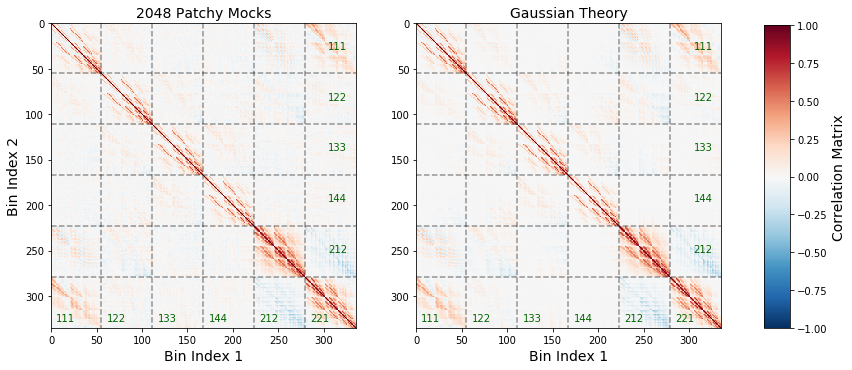

In [8]:
# Maximum number of multiplets to plot
n_max = 6

fig,ax = plt.subplots(1,2,figsize=(12,6))
# Sample correlation
im = ax[0].imshow(corr[:n_max*n_radial,:n_max*n_radial],vmax=1,vmin=-1,cmap=cm.RdBu_r);
# Theory correlation
im = ax[1].imshow(theory_corr[:n_max*n_radial,:n_max*n_radial],vmax=1,vmin=-1,cmap=cm.RdBu_r);
for i in range(n_max):
    for a in range(2):
        if i!=0: ax[a].hlines(n_radial*i-1,0,n_max*n_radial,linestyles='--',alpha=0.4)
        if i!=0: ax[a].vlines(n_radial*i-1,0,n_max*n_radial,linestyles='--',alpha=0.4)
        if i!=n_max-1: ax[a].text(n_radial*(n_max-1)+n_radial/10+20,n_radial*i+n_radial/2,'%d%d%d'%(ells[0][ang_filt][i],ells[1][ang_filt][i],ells[2][ang_filt][i]),color='darkgreen',size=10)
        ax[a].text(n_radial*i+n_radial/10,n_radial*(n_max-1)+n_radial/2+20,'%d%d%d'%(ells[0][ang_filt][i],ells[1][ang_filt][i],ells[2][ang_filt][i]),color='darkgreen',size=10)
for a in range(2):
    ax[a].set_xlim([0,n_radial*n_max-1])
    ax[a].set_ylim([n_radial*n_max-1,0])
ax[0].set_title('%d Patchy Mocks'%n_mocks,fontsize=14)
ax[1].set_title('Gaussian Theory',fontsize=14);
for a in range(2): ax[a].set_xlabel(r'Bin Index 1',fontsize=14)
ax[0].set_ylabel(r'Bin Index 2',fontsize=14)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.7])
cbar=fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Correlation Matrix',fontsize=14)

fig.savefig(plot_dir+'correlation_comparison.pdf',bbox_inches='tight')

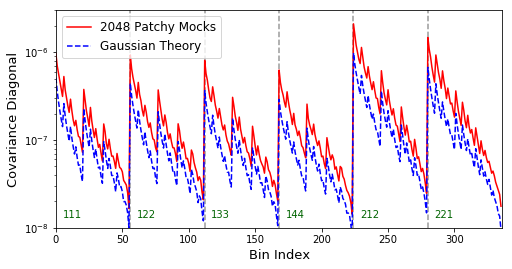

In [9]:
plt.figure(figsize=(8,4))
# Sample variance
plt.plot(np.diag(cov)[:n_max*n_radial],c='r',ls='-',label='%d Patchy Mocks'%n_mocks)
# Theory variance
plt.plot(np.diag(theory_cov)[:n_max*n_radial],c='b',ls='--',label='Gaussian Theory')
plt.yscale('log')
plt.xlim([0,n_max*n_radial])
ylims = [1e-8,3e-6]
plt.ylim(ylims)
for i in range(n_max):
    if i!=0: plt.vlines(n_radial*i,ylims[0],ylims[1],linestyles='--',alpha=0.4)
    plt.text(n_radial*i+n_radial/10,ylims[0]*1.3,'%d%d%d'%(ells[0][ang_filt][i],ells[1][ang_filt][i],ells[2][ang_filt][i]),color='darkgreen',size=10) 
plt.legend(loc='upper left',fontsize=12)
plt.xlabel(r'Bin Index',fontsize=13)
plt.ylabel(r'Covariance Diagonal',fontsize=13)

plt.savefig(plot_dir+'variance_comparison.pdf',bbox_inches='tight')

### 3b) Test for Likelihood Non-Gaussianity

- Below, we plot the empirical distribution of the pseudo-$\chi^2$ statistic from a set of Patchy mocks
- This is compared to the expected distribution from Gaussian statistics, with the mean and variance estimated from a second set of Patchy mocks.
- The difference between the two distributions implies that the statistic cannot be well-described as Gaussian.

In [10]:
# Mocks used to generate covariance
mocks1 = filt_flat_fourpcf[:500]
# Mocks used to plot empirical distribution
mocks2 = filt_flat_fourpcf[500:]

# Define mean and covariance from first set of mocks
cov1 = np.cov(mocks1.T)
mean1 = np.mean(mocks1,axis=0)

# Resample based on this distribution
mocks3 = np.random.multivariate_normal(mean1,cov1,100000)

# Define pseudo-chi2 statistic for each dataset
pseudo_chi2 = lambda m: np.inner(m,np.inner(inv_theory_cov,m))
pc1 = np.asarray([pseudo_chi2(mm) for mm in mocks1])
pc2 = np.asarray([pseudo_chi2(mm) for mm in mocks2])
pc3 = np.asarray([pseudo_chi2(mm) for mm in mocks3])

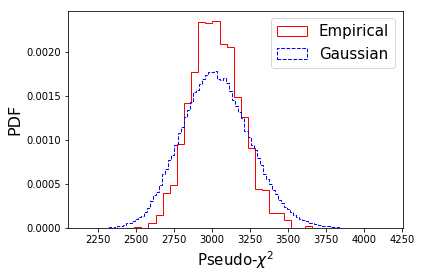

In [11]:
# Plot distribution
plt.hist(pc2,bins=25,label='Empirical',density=1,alpha=1,histtype='step',color='r',ls='-')
plt.hist(pc3,bins=100,label='Gaussian',density=1,alpha=1,histtype='step',color='b',ls='--')
plt.xlabel(r'Pseudo-$\chi^2$',fontsize=15)
plt.legend(fontsize=15);
plt.ylabel('PDF',fontsize=16);
plt.savefig(plot_dir+'pseudo_chi2_non-gaussianity.pdf',bbox_inches='tight')

# 4) Plot Data
- We plot a selection of odd 4PCF multiplets, $\zeta_{\ell_1\ell_2\ell_3}(r_1,r_2,r_3)$ below.
- The eventual analysis makes use of all odd-parity multiplets given the above restrictions.
- The three radial bins are collapsed into one-dimension, with the restriction $r_1<r_2<r_3$.
- The first panel gives the radial bin centers and the subsequent panels give the multiplets, normalized by $r_1r_2r_3$.

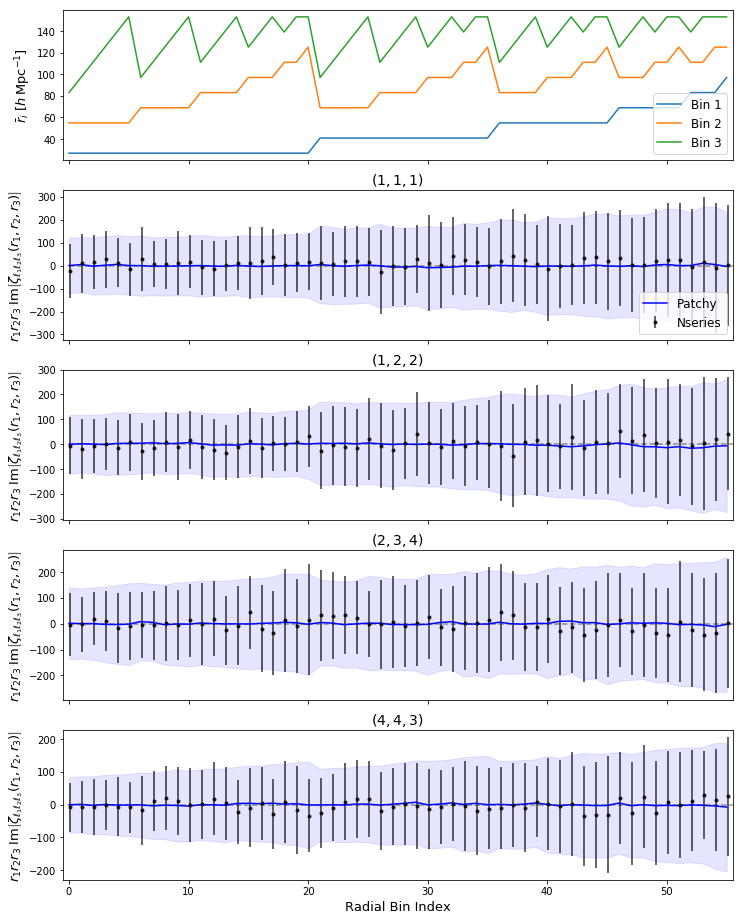

In [12]:
xmax = n_radial-1
r123 = (radii[0]*radii[1]*radii[2])[radial_filt]

# Choose which multiplet indices to plot
which_indices = [0,1,8,22]
n_plots = len(which_indices)

# Plot radial bins in first panel
fig,ax = plt.subplots(n_plots+1,figsize=(12,4*n_plots),sharex=True)
ax[0].plot(np.arange(n_radial),radii[0][radial_filt],label='Bin 1')
ax[0].plot(np.arange(n_radial),radii[1][radial_filt],label='Bin 2')
ax[0].plot(np.arange(n_radial),radii[2][radial_filt],label='Bin 3')
ax[0].set_xlim([-0.5,xmax+0.5])
ax[0].set_ylabel(r'$\bar r_i$ [$h\,\mathrm{Mpc}^{-1}$]',fontsize=13)
ax[0].legend(loc='lower right',fontsize=12)

# Define mean and variance of Patchy mocks
fourpcf_mean = np.mean(filt_fourpcf,axis=0)
fourpcf_std = np.std(filt_fourpcf,axis=0)#/np.sqrt(84.)

# Define mean and variance of Nseries mocks
fourpcf_nseries_mean = np.mean(filt_fourpcf_nseries,axis=0)
fourpcf_nseries_std = np.std(filt_fourpcf_nseries,axis=0)#/np.sqrt(84.)

# Iterate over multiplets to plot
for ii,i in enumerate(which_indices):
    
    # Plot Patchy data
    ax[ii+1].fill_between(np.arange(n_radial),r123*(fourpcf_mean[i]-fourpcf_std[i]),
                     r123*(fourpcf_mean[i]+fourpcf_std[i]),color='b',alpha=0.1)
    ax[ii+1].plot(np.arange(n_radial),r123*fourpcf_mean[i],label=r'Patchy',c='b')

    # Plot Nseries data
    ax[ii+1].errorbar(np.arange(n_radial)+0.1,r123*fourpcf_nseries_mean[i],yerr=r123*fourpcf_nseries_std[i],
                     ls='',c='k',marker='.',label=r'Nseries',alpha=0.8)
    
    ax[ii+1].hlines(0,0,n_radial,linestyles='--',color='k',alpha=0.4)
    
    if ii==0: ax[ii+1].legend(loc='lower right',fontsize=12)
    ax[ii+1].set_ylabel(r'$r_1r_2r_3\;\mathrm{Im}\left[\zeta_{\ell_1\ell_2\ell_3}(r_1,r_2,r_3)\right]$',fontsize=13)
    ax[ii+1].set_title(r'$(%d,%d,%d)$'%(ells[0][ang_filt][i],ells[1][ang_filt][i],ells[2][ang_filt][i]),fontsize=14);

ax[n_plots].set_xlabel(r'Radial Bin Index',fontsize=13)
fig.savefig(plot_dir+'4pcf_main_plot.pdf',bbox_inches='tight')

# 5) Perform a non-parametric rank test
- A rigorous test for parity-violation is to perform a non-parametric rank test, comparing the distribution of a test statistic measured in data to that from realistic (parity-conserving) simulations
- We first define the *pseudo*-$\chi^2$ statistic $S = [d^T \tilde{\mathsf C}^{-1} d]_\mathrm{NGC}$ for theory covariance $\tilde{\mathsf{C}}$. This is a sensible choice since the data is likely close to Gaussian and the theory covariance is likely close to the truth. We only use the NGC region here.
- We plot the distribution of $S$ from the Patchy mocks, and add also that from the Nseries mocks.
- The rank of the Nseries mocks gives the significance of the detection.
- This avoids (a) assuming that the theory covariance matches the true covariance and (b) assuming a likelihood for the data (*i.e.* asserting Gaussianity).

In [13]:
def pseudo_chi2(data):
    """Define the pseudo-chi^2 statistic from NGC data. 
    This is constructed using the (biased) theory covariance.
    We add the summaries from the two statistics together, assuming independence."""
    theory = np.zeros_like(data)
    x = np.inner(data-theory, np.inner(inv_theory_cov, data-theory))
    return x

pseudo_chi2_patchy = np.asarray([pseudo_chi2(filt_flat_fourpcf[i]) for i in range(n_mocks)])
pseudo_chi2_nseries = np.asarray([pseudo_chi2(filt_flat_fourpcf_nseries[i]) for i in range(n_nseries)])

nseries_percentile = np.asarray([percentileofscore(pseudo_chi2_patchy,pseudo_chi2_nseries[i]) for i in range(n_nseries)])
nseries_rank = nseries_percentile*n_mocks/100.

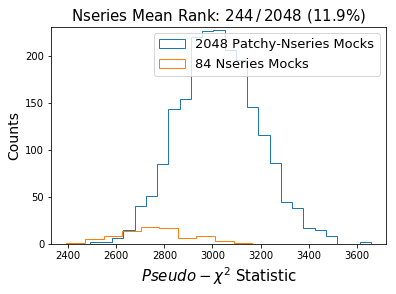

In [14]:
plt.figure(figsize=(6,4))
ct,x,_=plt.hist(pseudo_chi2_patchy,bins=25,label='%d Patchy-Nseries Mocks'%n_mocks,histtype='step');
ct2,x2,_=plt.hist(pseudo_chi2_nseries,bins=10,label='%d Nseries Mocks'%n_nseries,histtype='step');
plt.ylim(0,max(ct)+4)
plt.xlabel(r'${Pseudo}-\chi^2$ Statistic',fontsize=15);
plt.ylabel(r'Counts',fontsize=14)
plt.title(r'Nseries Mean Rank: $%d\,/\,%d$ (%.1f%%)'%(nseries_rank.mean(),n_mocks,nseries_percentile.mean()),fontsize=15)
plt.legend(fontsize=13)
plt.savefig(plot_dir+'non-parametric-plot.pdf',bbox_inches='tight')

## 5a) Analyze with Rescaled Theory Covariance

- An alternative way in which to analyze the data is to use the *theoretical* covariance matrix to form the $\chi^2$:
$$\chi^2 = \zeta^T \mathsf{C}_{\rm theory}^{-1}\zeta$$ 
and analyze assuming Gaussian statistics. 
- We can improve the fit of theory and sample covariances by adjusting the effective survey volume (and optionally shot-noise).
- As in Hou et al. (2021), this is fit using the Kullback-Leibler divergence, comparing the true and theory covariances.
- We caution that this is **not** a robust way to analyze the data, since the theoretical covariance is unlikely to fully represent the data, even after a volume rescaling. As shown in Philcox, Hou & Slepian (2021), when this method is applied to the even-parity 4PCF, it can lead to a significant misdetection of non-Gaussianity. 
- We include the results for completeness however.

In [15]:
stack_fourpcf = filt_flat_fourpcf.copy()
stack_fourpcf_mean = np.mean(stack_fourpcf,axis=0)
stack_fourpcf_nseries = filt_flat_fourpcf_nseries.copy()

# Define a combined covariance matrix
inv_stack_theory_cov = np.linalg.inv(theory_cov)
stack_cov = np.cov(stack_fourpcf.T)

# Compute an optimal rescaling factor
trace_disc_0 = np.trace(np.matmul(inv_stack_theory_cov,stack_cov))
logdet0 = np.linalg.slogdet(inv_stack_theory_cov)[1]
def KL_div(rescaling):
    """Use the Kullback-Leibler divergence to give the log-likelihood for the rescaling."""
    return trace_disc_0/rescaling-(logdet0-np.log(rescaling)*len(theory_cov))

opt_rescaling = minimize(KL_div,1.).x
print("Optimal Rescaling: %.2fx"%opt_rescaling)

# Rescale theory matrix
opt_theory_cov = theory_cov*opt_rescaling
inv_opt_theory_cov = inv_stack_theory_cov/opt_rescaling

Optimal Rescaling: 2.35x


**Compare sample and theory covariances**
- We plot the ratio of the Patchy sample covariance to the theory covariance diagonal.
- Including the volume rescaling significantly improves the fit, but it is still imperfect, with significant structure remaining.

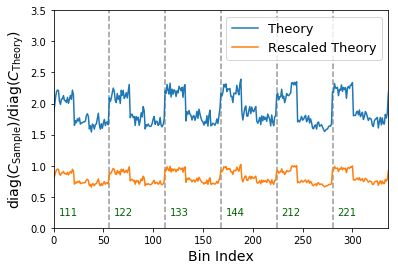

In [16]:
plt.plot(np.diag(cov)/np.diag(theory_cov),label='Theory')
plt.plot(np.diag(cov)/np.diag(opt_theory_cov)[:n_mult*n_radial],label='Rescaled Theory')
plt.ylabel(r'$\mathrm{diag}(C_{\rm Sample})/\mathrm{diag}(C_{\rm Theory})$',fontsize=14)
plt.legend(fontsize=13)#,loc='center right')
plt.xlim([0,n_max*n_radial])
plt.ylim([0,3.5])
for i in range(n_max):
    if i!=0: plt.vlines(n_radial*i,0,4,linestyles='--',alpha=0.4)
    plt.text(n_radial*i+n_radial/10,0.2,'%d%d%d'%(ells[0][ang_filt][i],ells[1][ang_filt][i],ells[2][ang_filt][i]),color='darkgreen',size=10) 
plt.xlabel(r'Bin Index',fontsize=14)
plt.savefig(plot_dir+'fitted_variance_comparison.pdf',bbox_inches='tight')

**Plot the detection PDFs obtained from a classical $\chi^2$ analysis with a rescaled theory covariance**
- This uses the fitted-theory $\chi^2$s, and is thus not expected to be accurate.
- Both the empirical distribution of Patchy mocks and the Nseries mocks are plotted.
- We see the empirical distribution does not match the theory distribution, likely indicating the insufficiency of the theoretical covariance matrix.

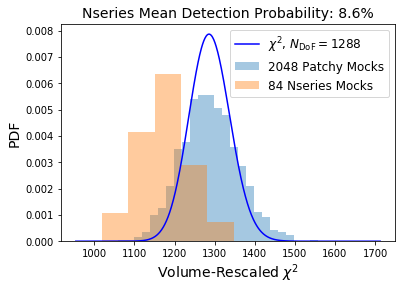

In [17]:
# Compute the chi^2 statistics
theory_model = np.zeros_like(stack_fourpcf_nseries[0])
opt_chi2 = np.asarray([np.inner(dd-theory_model,np.inner(inv_opt_theory_cov,dd-theory_model)) for dd in stack_fourpcf])
opt_chi2_nseries = np.asarray([np.inner(dd-theory_model,np.inner(inv_opt_theory_cov,dd-theory_model)) for dd in stack_fourpcf_nseries])

# Plot the chi^2 PDF of the Patchy mocks, the Nseries mocks and the analytic Gaussian PDF
bins = 25
plt.figure()
ct,x,_=plt.hist(opt_chi2,bins=bins,alpha=0.4,density=1,label=r'%d Patchy Mocks'%n_mocks)
ct2,x2,_=plt.hist(opt_chi2_nseries,bins=bins/5,alpha=0.4,density=1,label=r'%d Nseries Mocks'%n_nseries)
x_arr = np.arange(min(x)*0.9,max(x)*1.1)
p = len(stack_fourpcf_nseries[0])
chi2_pdf = chi2.pdf(x_arr,p)
nseries_prob = chi2.cdf(opt_chi2_nseries,p)
plt.title(r'Nseries Mean Detection Probability: %.1f%%'%(100.*nseries_prob.mean(axis=0)),fontsize=14)
plt.plot(x_arr,chi2_pdf,color='blue',label=r'$\chi^2$, $N_\mathrm{DoF} = %d$'%p)
plt.legend(fontsize=12);
plt.ylim([0,max([max(ct),max(chi2_pdf)])*1.05])
plt.xlabel(r'Volume-Rescaled $\chi^2$',fontsize=14)
plt.ylabel(r'PDF',fontsize=14)
plt.savefig(plot_dir+'vol_rescaled_chi2.pdf',bbox_inches='tight')

# 6) Perform data compression

- We now analyze the data using the compression scheme in Philcox (2021), based on Scoccimarro (2000).
- Data are projected onto the eigenvectors of the *model* inverse covariance matrix.
- This would be an optimal projection if true = model covariance, in the Gaussian limit, and is always unbiased.
- Here, the statistic is defined as $v = U^T\zeta$ where $\tilde{\mathsf C} = U\Lambda U^T$, and we keep the first $N_\mathrm{eig}$ eigenvectors, which are ordered in inverse-variance, i.e. we use those with the smallest $\Lambda$ (though other schemes are also possible). Note that $v_{\rm theory} = 0$ under null assumptions.
- The covariance matrix of $v$ is *close* to diagonal, with $\langle vv^T \rangle = U^TC_DU$. If $C_D = \tilde{\mathsf{C}} = U\Lambda U^T$, then $\langle vv^T \rangle = \Lambda$, which is diagonal.
- We use only the NGC data here.

In [18]:
### Order the eigenvectors by inverse signal-to-noise
evals = evalstheory[::-1]
evecs = evecstheory[:,::-1]

### Now project data
def project_data(data,N_eig,patch='ngc'):
    """Project data onto the eigenvector basis for NGC."""
    these_evecs = evecs[:,:N_eig]
    proj_data = np.matmul(these_evecs.T,data.T).T
    return proj_data

N_eig = 100
projected_fourpcf = project_data(filt_flat_fourpcf,N_eig,'ngc')
projected_fourpcf_nseries = project_data(filt_flat_fourpcf_nseries,N_eig,'ngc')

**Compressed Covariance**
- We plot the covariance matrix of the compressed 4PCF. 
- This should be close to diagonal if the projection is optimal.

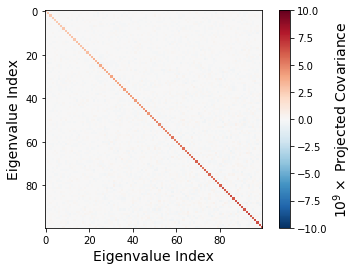

In [19]:
plt.imshow(1e9*np.cov(projected_fourpcf.T),cmap=cm.RdBu_r,vmax=10,vmin=-10);
fs = 14
cbar = plt.colorbar();
plt.xlabel(r'Eigenvalue Index',fontsize=fs)
plt.ylabel(r'Eigenvalue Index',fontsize=fs)
cbar.set_label(r'$10^9 \times$ Projected Covariance',fontsize=fs)
plt.savefig(plot_dir+'projected_4pcf_cov.pdf',bbox_inches='tight')

**Compressed Data**
- We visualize the compressed data directly. 
- A robust detection of parity-violation would be indicated by data-points that are well separated from zero (either above or below).`

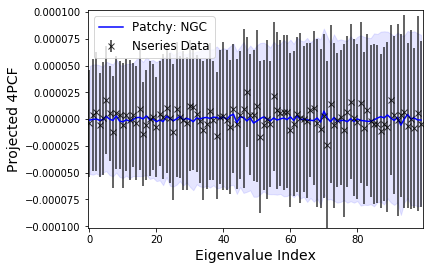

In [20]:
mean = projected_fourpcf.mean(axis=0)
std = projected_fourpcf.std(axis=0)
i_arr = np.arange(len(mean))
plt.errorbar(i_arr,mean,label='Patchy: NGC',c='b')
plt.errorbar(i_arr,projected_fourpcf_nseries.mean(axis=0),ls='',marker='x',alpha=0.8,
             yerr=projected_fourpcf_nseries.std(axis=0),label='Nseries Data',c='k')
plt.fill_between(i_arr,mean-std,mean+std,alpha=0.1,color='b')
plt.xlabel(r'Eigenvalue Index',fontsize=14)
plt.ylabel(r'Projected 4PCF',fontsize=14)
plt.xlim([-0.5,N_eig-0.5])
plt.legend(fontsize=12,loc='upper left')
vmax = np.max(mean+std)
plt.ylim([-vmax*1.2,vmax*1.2])
plt.savefig(plot_dir+'projected_4pcf_data.pdf',bbox_inches='tight')

# 7) Perform a Gaussian hypothesis test for the projected statistic

- Given projected data $v$, we form the test statistic:

$$T^2 = v^T\hat{\mathsf{C}}_v^{-1}v,$$
where $\hat{\mathsf{C}}$ is the projected sample covariance matrix, and we assume zero sample mean, matching the null hypothesis of no non-Gaussianity. 
- As in Sellentin & Heavens (2016), this follows a modified $F$-distribution, such that
$$T^2\sim \frac{\Gamma\left(\frac{n+1}{2}\right)}{\Gamma(p/2)\Gamma[(n-p+1)/2]}\frac{n^{-p/2}(T^2)^{p/2-1}}{(T^2/n+1)^{(n+1)/2}}$$
where $p = \mathrm{dim}(v)$ and $n = N_\mathrm{mocks}-1$.
- We can also form the conventional $\chi^2$ statistic, including the Hartlap factor required to debias noisy inverse covariance matrices:
$$H^2 = f_H\times v^T\hat{\mathsf{C}}^{-1}v,$$ where $f_H = (n-p-1)/n$. This is usually assumed to follow $\chi^2$ statistics, *i.e.* $H^2\sim \chi^2_p$, but this breaks down at small $n$.
- Both distributions are considered below. To form empirical distributions we apply jackknifing, computing the covariance from $(N-1)$ mocks and repeating.
- Below, analysis is performed for several choices of $N_\mathrm{eig}$, and we plot the detection PDFs and CDFs.

As in Philcox (2022), we show results using $N_{\rm eig} \in \{10,50,100,250\}$ basis vectors.



N_eig = 10
Jackknifing to compute empirical Patchy covariances. This may take a while...
On step 100 of 2048
On step 200 of 2048
On step 300 of 2048
On step 400 of 2048
On step 500 of 2048
On step 600 of 2048
On step 700 of 2048
On step 800 of 2048
On step 900 of 2048
On step 1000 of 2048
On step 1100 of 2048
On step 1200 of 2048
On step 1300 of 2048
On step 1400 of 2048
On step 1500 of 2048
On step 1600 of 2048
On step 1700 of 2048
On step 1800 of 2048
On step 1900 of 2048
On step 2000 of 2048
Hartlap Factor for jackknifed PDF: 0.995
Hartlap Factor for Nseries: 0.995

Fraction of 2-sigma detections with 10 eigenvalues
chi^2 + Hartlap model: 0.050
T^2: 0.050
Expected: 0.050

Fraction of mocks outside the 95% region with 10 eigenvalues
chi^2 + Hartlap model: 0.054
T^2: 0.054
Expected: 0.050

Nseries Mean Detection Rates:
chi^2 + Hartlap model: 0.521
T^2: 0.521
Effective Sigmas: 1.21


N_eig = 50
Jackknifing to compute empirical Patchy covariances. This may take a while...
On step 100 

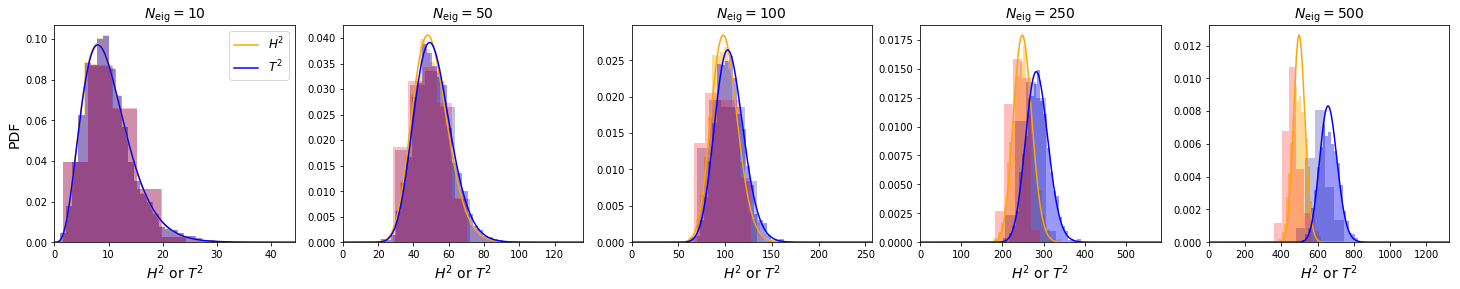

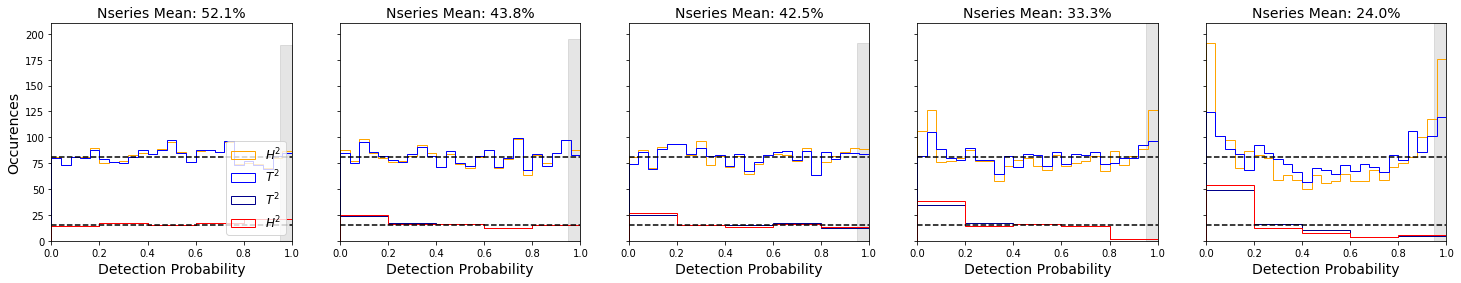

In [21]:
# List of numbers of basis vectors to test
N_eigs = [10,50,100,250,500]

# Number of histogram bins
bins = 25

fig1,ax1 = plt.subplots(1,len(N_eigs),figsize=(5*len(N_eigs),4))
fig2,ax2 = plt.subplots(1,len(N_eigs),figsize=(5*len(N_eigs),4),sharey=True)

for nn,N_eig in enumerate(N_eigs):
    print("\n\nN_eig = %d"%N_eig)
    
    # Project the data onto the basis
    projected_fourpcf = project_data(filt_flat_fourpcf,N_eig,'ngc')
    projected_fourpcf_nseries = project_data(filt_flat_fourpcf_nseries,N_eig,'ngc')
    
    ### Compute distribution of mock data using sets of (N-1) mocks, i.e. jackknifing
    this_n_mocks = len(projected_fourpcf)-1
    
    all_T2, all_H2 = [],[]
    print("Jackknifing to compute empirical Patchy covariances. This may take a while...")
    for i in range(len(projected_fourpcf)):
        if (i+1)%100==0: print("On step %d of %d"%(i+1,len(projected_fourpcf)))

        # Define data
        projected_mock = projected_fourpcf[i]
        
        # Define sample covariance in projected space
        projected_cov = np.cov(projected_fourpcf[np.arange(len(projected_fourpcf))!=i].T)
        
        # Invert the covariance
        inv_projected_cov = np.linalg.inv(projected_cov)
        
        # Compute the sample statistic
        T2_statistic = np.inner(projected_mock,np.inner(inv_projected_cov,projected_mock))
        all_T2.append(T2_statistic)
    
    all_T2 = np.asarray(all_T2)
    
    # Compute also Hartlap-rescaled statistic
    hartlap_factor = (this_n_mocks-N_eig-2.)/(this_n_mocks-1)
    print("Hartlap Factor for jackknifed PDF: %.3f"%hartlap_factor)
    all_H2 = all_T2*hartlap_factor
    
    ### Compute T2 and H2 statistics on Nseries data using every mmock
    projected_cov = np.cov(projected_fourpcf.T)
    inv_projected_cov = np.linalg.inv(projected_cov)
    T2_nseries = np.asarray([np.inner(projected_fourpcf_nseries[i],np.inner(inv_projected_cov,projected_fourpcf_nseries[i])) for i in range(n_nseries)])
    hartlap_factor = (n_mocks-N_eig-2.)/(n_mocks-1)
    print("Hartlap Factor for Nseries: %.3f"%hartlap_factor)
    H2_nseries = T2_nseries*hartlap_factor
    
    ### Compute PDFs and CDFs (easiest to do CDFs numerically with a fine grid)
    mmax = max(all_T2)*1.5
    x_arr = np.linspace(0.001,mmax,10000)
    x2_arr = 0.5*(x_arr[:-1]+x_arr[1:])
    p = N_eig
    n = n_mocks-1
    chi2_pdf = chi2.pdf(x2_arr,p)
    T2_pdf = np.float128(np.exp((p/2.-1.)*np.log(x2_arr)-p/2.*np.log(n)-0.5*(n+1.)*np.log(x2_arr/n+1.))*np.exp(loggamma((n+1.)/2.)-loggamma(p/2.)-loggamma((n-p+1.)/2.)))

    # Compute CDFs
    chi2_cdf = interp1d(x2_arr,np.cumsum(chi2_pdf)*np.diff(x_arr)[0])
    T2_cdf = interp1d(x2_arr,np.cumsum(T2_pdf)*np.diff(x_arr)[0])

    ### Plot empirical distributions
    ct,_,_=ax1[nn].hist(all_H2,bins=bins,alpha=0.4,density=1,color='orange')#,label=r'$H^2$')
    ax1[nn].hist(all_T2,bins=bins,alpha=0.4,density=1,color='blue')#,label=r'$T^2$');
    ax1[nn].hist(T2_nseries,bins=bins/5,alpha=0.25,density=1,color='darkblue')
    ax1[nn].hist(H2_nseries,bins=bins/5,alpha=0.25,density=1,color='red')
    
    ### Plot theoretical distributions
    ax1[nn].plot(x2_arr,chi2_pdf,color='orange',label=r'$H^2$')
    ax1[nn].plot(x2_arr,T2_pdf,color='blue',label=r'$T^2$')
    
    ### Add cosmetics
    if nn==0:
        ax1[nn].legend(fontsize=12);
    ax1[nn].set_xlim([0,mmax])
    ax1[nn].set_ylim([0,max([max(ct),max(chi2_pdf)])*1.05])
    ax1[nn].set_xlabel(r'$H^2$ or $T^2$',fontsize=14)
    if nn==0: ax1[nn].set_ylabel(r'PDF',fontsize=14)
    ax1[nn].set_title(r'$N_\mathrm{eig} = %d$'%N_eig,fontsize=14);
    if nn==N_eig-1: fig1.savefig(plot_dir+'projected_pdfs_all.pdf',bbox_inches='tight')

    ### Compute detection probabilities, as a 1-tail test
    prob_T2 = T2_cdf(all_T2)
    prob_chi2 = chi2_cdf(all_H2)

    prob_T2_nseries = T2_cdf(T2_nseries)
    prob_chi2_nseries = chi2_cdf(H2_nseries)

    # Count fraction of false detections 
    N_detections_T2 = (np.sum(prob_T2>0.95))*1./n_mocks
    N_detections_chi2 = (np.sum(prob_chi2>0.95))*1./n_mocks

    print("\nFraction of 2-sigma detections with %d eigenvalues"%N_eig)
    print("chi^2 + Hartlap model: %.3f"%N_detections_chi2)
    print("T^2: %.3f"%N_detections_T2)
    print("Expected: %.3f"%(0.05))

    # Count fraction of values outside the 95\% region 
    N_detections_T2_twosided = (np.sum(prob_T2>0.975)+np.sum(prob_T2<0.025))*1./n_mocks
    N_detections_chi2_twosided = (np.sum(prob_chi2>0.975)+np.sum(prob_chi2<0.025))*1./n_mocks

    print("\nFraction of mocks outside the 95%% region with %d eigenvalues"%N_eig)
    print("chi^2 + Hartlap model: %.3f"%N_detections_chi2_twosided)
    print("T^2: %.3f"%N_detections_T2_twosided)
    print("Expected: %.3f"%(0.05))

    print("\nNseries Mean Detection Rates:")
    print("chi^2 + Hartlap model: %.3f"%prob_chi2_nseries.mean())
    print("T^2: %.3f"%prob_T2_nseries.mean())
    print("Effective Sigmas: %.2f"%np.sqrt(-2.*np.log(1.-prob_T2_nseries.mean())))

    ### Histogram the detection PDFs
    ax2[nn].set_title(r'Nseries Mean: %.1f%%'%(100.*prob_T2_nseries.mean()),fontsize=14)
    ct,_,_=ax2[nn].hist(prob_chi2,bins=bins,histtype='step',color='orange',label=r'$H^2$',density=0,range=[0,1.00001]);
    ax2[nn].hist(prob_T2,bins=bins,histtype='step',color='blue',label=r'$T^2$',density=0,range=[0,1.00001]);
    ax2[nn].hlines(n_mocks/bins,0,1,linestyles='--')
    ax2[nn].hlines(n_nseries/bins*5.,0,1,linestyles='--')
    ax2[nn].hist(prob_T2_nseries,bins=bins/5,histtype='step',color='darkblue',label=r'$T^2$',density=0,range=[0,1.00001]);
    ct2,_,_=ax2[nn].hist(prob_chi2_nseries,bins=bins/5,histtype='step',color='red',label=r'$H^2$',density=0,range=[0,1.00001]);
    ax2[nn].set_xlim([0.0,1])
    ax2[nn].fill_betweenx(np.arange(0,max(ct)*2),0.95,1,alpha=0.1,color='k')
    ax2[nn].set_ylim([0,max(ct)*1.1])
    if nn==0: ax2[nn].legend(fontsize=12,loc='lower right');
    if nn==0: ax2[nn].set_ylabel(r'Occurences',fontsize=14)
    ax2[nn].set_xlabel(r'Detection Probability',fontsize=14);
    if nn==N_eig-1:
        fig2.savefig(plot_dir+'projected_cdfs_all.pdf',bbox_inches='tight')

# 8) Compare to the Chern-Simons 4PCF Model

- A possible source of parity-violation in the isotropic 4PCF is given by Chern-Simons interactions in the early Universe, between a pseudo-scalar axion and the electromagnetic field
- As demonstrated in [Shiraishi 2016](https://arxiv.org/abs/1608.00368) for the CMB and Philcox (2022) for LSS, this model leads to a definite shape in the isotropic 4PCF of galaxies, whose amplitude we can probe.
- Below, we place constraints on the template amplitude, $A_{\rm CS}$, by performing a classical $\chi^2$ analysis in the compressed subspace, using the sample covariance matrices, and assuming Gaussianity. 
- Unlike previously, we choose the basis vectors by maximizing signal-to-noise, to obtain tightest constraints on the Chern-Simons model.
- The templates may be constructed for arbitrary $\ell_{\rm max}$ and binning schemes using the accompanying Python code ```compute_cs_4pf.py``` (and ```compute_general_4pcf.py``` for the $d^{\rm odd}_{0,1}$ decomposition). We provide a template computed with the above binning parameters, including all odd multiplets up to $\ell_{\rm max} = 4$.
- To generate the template we assume the Patchy cosmology, a linear bias of $b = 2$, and use $\ell_{\rm max} = 8$  for internal angular momentum couplings.

#### Parameters

In [22]:
# Whether to also compute d_n^odd constraints
compute_d_odd = False

# Sampling parameters
positive_amplitude = False
N_eig = 100
gamma = 1 # Chern-Simons coupling strength (relative to parity-even term)

#### Load Templates

In [23]:
### First load in the Chern-Simons model
fourpcf_CS = np.loadtxt(data_dir+'chern_simons_4pcf_model.txt',dtype='complex')

### Take imaginary part, and restrict to the relevant radial bins
## Note that there is an additional factor of -1 in the template definition
filt_fourpcf_CS = fourpcf_CS.imag[:,radial_filt]*-1.

if compute_d_odd:
    ### Load in the d^odd components
    fourpcf_CS_d0 = -1.*np.loadtxt(data_dir+'d0_odd_4pcf_model.txt',dtype='complex')
    fourpcf_CS_d1 = 1./3.*np.loadtxt(data_dir+'d1_odd_4pcf_model.txt',dtype='complex')

    ### Take imaginary part, and restrict to the relevant radial bins
    ## Note that there is an additional factor of -1 in the template definition
    filt_fourpcf_CS_d0 = fourpcf_CS_d0.imag[:,radial_filt]*-1.
    filt_fourpcf_CS_d1 = fourpcf_CS_d1.imag[:,radial_filt]*-1.

**Compare the Chern-Simons 4PCF model to data**
- For clarity, we plot only a small selection of multipoles.
- A fiducial value $A_{\rm CS}=5\times 10^4$ is chosen to ensure visibility.

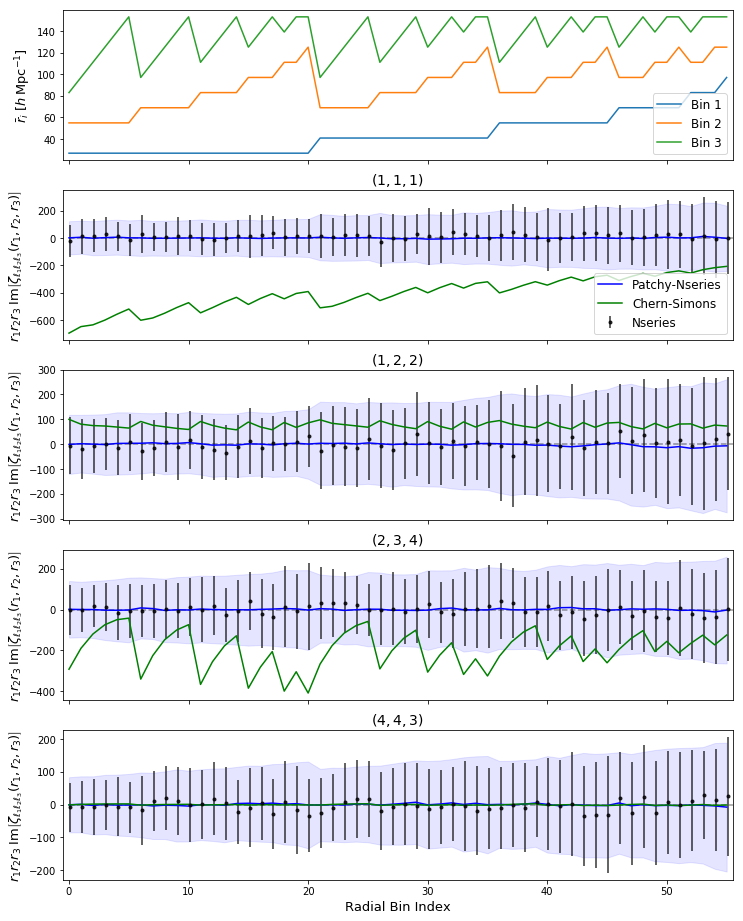

In [24]:
xmax = n_radial-1
r123 = (radii[0]*radii[1]*radii[2])[radial_filt]

fiducial_amplitude = 5e4
fiducial_amplitude_d0 = -fiducial_amplitude
fiducial_amplitude_d1 = 3.*fiducial_amplitude

# Choose which multiplet indices to plot
which_indices = [0,1,8,22]
n_plots = len(which_indices)

# Plot radial bins in first panel
fig,ax = plt.subplots(n_plots+1,figsize=(12,4*n_plots),sharex=True)
ax[0].plot(np.arange(n_radial),radii[0][radial_filt],label='Bin 1')
ax[0].plot(np.arange(n_radial),radii[1][radial_filt],label='Bin 2')
ax[0].plot(np.arange(n_radial),radii[2][radial_filt],label='Bin 3')
ax[0].set_xlim([-0.5,xmax+0.5])
ax[0].set_ylabel(r'$\bar r_i$ [$h\,\mathrm{Mpc}^{-1}$]',fontsize=13)
ax[0].legend(loc='lower right',fontsize=12)

# Define mean and variance of mocks
fourpcf_mean = np.mean(filt_fourpcf,axis=0)
fourpcf_std = np.std(filt_fourpcf,axis=0)

# Iterate over multiplets to plot
for ii,i in enumerate(which_indices):
    
    # Plot Patchy data
    ax[ii+1].fill_between(np.arange(n_radial),r123*(fourpcf_mean[i]-fourpcf_std[i]),
                     r123*(fourpcf_mean[i]+fourpcf_std[i]),color='b',alpha=0.1)
    ax[ii+1].plot(np.arange(n_radial),r123*fourpcf_mean[i],label=r'Patchy-Nseries',c='b')
  
    # Plot Nseries data
    ax[ii+1].errorbar(np.arange(n_radial)+0.1,r123*filt_fourpcf_nseries.mean(axis=0)[i],
                      yerr=r123*filt_fourpcf_nseries.std(axis=0)[i],
                     ls='',c='k',marker='.',label=r'Nseries',alpha=0.8)
    
    ax[ii+1].plot(np.arange(n_radial),r123*fiducial_amplitude*filt_fourpcf_CS[i],label=r'Chern-Simons',c='green')
    if compute_d_odd:
        ax[ii+1].plot(np.arange(n_radial),r123*fiducial_amplitude_d0*filt_fourpcf_CS_d0[i],label=r'$d^{\rm odd}_0$',c='red',ls='--')
        ax[ii+1].plot(np.arange(n_radial),r123*fiducial_amplitude_d1*filt_fourpcf_CS_d1[i],label=r'$d^{\rm odd}_1$',c='purple',ls='--')

    ax[ii+1].hlines(0,0,n_radial,linestyles='--',color='k',alpha=0.4)
    
    if ii==0: ax[ii+1].legend(loc='lower right',fontsize=12)
    ax[ii+1].set_ylabel(r'$r_1r_2r_3\;\mathrm{Im}\left[\zeta_{\ell_1\ell_2\ell_3}(r_1,r_2,r_3)\right]$',fontsize=13)
    ax[ii+1].set_title(r'$(%d,%d,%d)$'%(ells[0][ang_filt][i],ells[1][ang_filt][i],ells[2][ang_filt][i]),fontsize=14);

ax[n_plots].set_xlabel(r'Radial Bin Index',fontsize=13)
fig.savefig(plot_dir+'4pcf_CS_plot.pdf',bbox_inches='tight')

**Perform Parameter Inference**
- We use the $t$-distribution likelihood of Sellentin \& Heavens 2016, which gives:
$$\log L(\theta) = -\frac{N_{\rm mocks}}{2}\log\left[1+\frac{T^2(\theta)}{N_{\rm mocks}-1}\right]+ \text{const.}$$
where $T^2(\theta) = [d-m(\theta)]^TS^{-1}[d-m(\theta)]$ for (compressed) data $d$, model $m$ and sample covariance $S$.
- On physical grounds, $A_{\rm CS}$ is constrained to be positive. We can optionally impose this condition below using the ```positive_amplitude``` parameter.
- Sampling is performed using the $\texttt{emcee}$.

In [25]:
# Compute (squared) signal-to-noise of each eigenvector in the CS model
SN = np.matmul(evecstheory.T,filt_fourpcf_CS.ravel())**2.*evals

# Order the eigenvectors in termms of signal-to-noise
order = np.argsort(SN)[::-1]
evals_CS = evals[order]
evecs_CS = evecs[:,order]

### Project data and template
def project_data_CS(data,N_eig,patch='ngc'):
    """Project data onto the eigenvector basis for NGC."""
    if patch=='ngc':
        these_evecs = evecs_CS[:,:N_eig]
    else:
        raise Exception()
    proj_data = np.matmul(these_evecs.T,data.T).T
    return proj_data

projected_fourpcf = project_data_CS(filt_flat_fourpcf,N_eig,'ngc')
projected_fourpcf_nseries = project_data_CS(filt_flat_fourpcf_nseries,N_eig,'ngc')
projected_chern_simons_template = project_data_CS(filt_fourpcf_CS.ravel(),N_eig,'ngc')

if compute_d_odd:
    projected_d0_template = project_data_CS(filt_fourpcf_CS_d0.ravel(),N_eig,'ngc')
    projected_d1_template = project_data_CS(filt_fourpcf_CS_d1.ravel(),N_eig,'ngc')

projected_cov = np.cov(projected_fourpcf.T)
projected_fourpcfmean = projected_fourpcf.mean(axis=0)
inv_projected_cov = np.linalg.inv(projected_cov)

In [26]:
def T2_CS(A_CS,projected_template,patch='ngc',data='Nseries'):
    """Compute T^2 statistic for a given amplitude A_{CS} of the Chern-Simons term.
    If data='Nseries' we return the value for the mean of the Nseries mocks.
    If data='Patchy' we return the value for the mean of the Patchy mocks."""
    if data=='Nseries':
        diff = projected_fourpcf_nseries.mean(axis=0)-A_CS*projected_template
    elif data=='Patchy':
        diff = projected_fourpcfmean-A_CS*projected_template
    inv_cov = inv_projected_cov
    T2 = np.sum(diff.T*np.matmul(inv_cov,diff.T),axis=0)
    return T2

def loglik_CS(A_CS,projected_template,data='Nseries'):
    """Compute the loglikelihood of A_CS from the mean of Nseries or the mean of Patchy.
    On physical grounds, we enforce A_CS>0."""
    loglik = np.log(1.+T2_CS(A_CS,projected_template,'ngc',data)/(n_mocks-1.))
    loglik = -n_mocks/2.*(loglik)
    if positive_amplitude:
        # Constrain A_CS to be positive!
        loglik -= 1e12*(A_CS<0)
    return loglik

In [27]:
def compute_mcmc_chain(dataset, projected_template):
    """Run an MCMC chain to determine A_CS from the dataset"""
    
    # Sample 1-parameter model using emcee
    pos = 100.*np.random.randn(32, 1)
    nwalkers, ndim = pos.shape

    sampler = emcee.EnsembleSampler(nwalkers, ndim, lambda A: loglik_CS(A, projected_template, data=dataset))
    sampler.run_mcmc(pos, 10000);

    flat_samples = sampler.flatchain[1000::10,0]
    return flat_samples

print("Computing Patchy CS chain")
flat_samples_patchy = compute_mcmc_chain('Patchy',projected_chern_simons_template)
print("Computing Nseries CS chain")
flat_samples_nseries = compute_mcmc_chain('Nseries',projected_chern_simons_template)

if compute_d_odd:
    print("Computing Patchy d0 chain")
    flat_samples_patchy_d0 = compute_mcmc_chain('Patchy',projected_d0_template)
    print("Computing Nseries d0 chain")
    flat_samples_nseries_d0 = compute_mcmc_chain('Nseries',projected_d0_template)
    print("Computing Patchy d1 chain")
    flat_samples_patchy_d1 = compute_mcmc_chain('Patchy',projected_d1_template)
    print("Computing Nseries d1 chain")
    flat_samples_nseries_d1 = compute_mcmc_chain('Nseries',projected_d1_template)

Computing Patchy CS chain
Computing Nseries CS chain


**Plot Histograms of Chern-Simons Amplitude**
- We plot both the $A_{\rm CS}$ 4PCF amplitude and its conversion to the physical parameter $\rho_E/\rho_\phi$
- The latter gives the ratio of the gauge field vacuum energy density and that of the inflaton.
- This depends strongly on the $\gamma$, *i.e.* the coupling strength. $\gamma = 1$ gives equal amplitude contributions from parity-even and parity-odd terms in the inflationary Lagrangian.

Using |gamma| = 1, N_eig = 100 and allowing both signs of A_CS

Nseries 1-sigma constraints: 10^-3 A_{CS} = 0.01 +- 0.85, 10^19 rho_E/rho_phi = 0.01 +- 0.69
Patchy 1-sigma constraints: 10^-3 A_{CS} = 0.03 +- 0.85, 10^19 rho_E/rho_phi = 0.02 +- 0.69


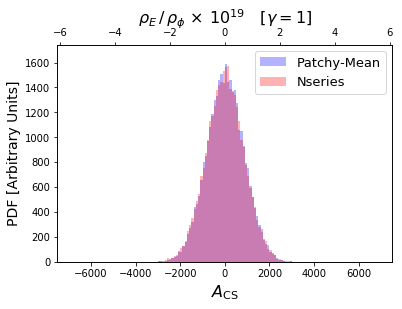

In [28]:
### Load conversion between A_CS and physical ratio of energy densities
if positive_amplitude:
    print("Using |gamma| = %d, N_eig = %d and forcing A_CS to be positive"%(abs(gamma),N_eig))
else:
    print("Using |gamma| = %d, N_eig = %d and allowing both signs of A_CS"%(abs(gamma),N_eig))

N = 60 # number of e-folds of inflation
epsilon = 0.01 # slow-roll parameter
gstar_rhoE_ratio = 5.4e5/np.pi*np.exp(4.*np.pi*abs(gamma))/abs(gamma)**3.*(0.01/epsilon)*(N/60.)**2.
A_CS_gstar_ratio = 0.3/np.pi**2.*np.exp(8.*np.pi*abs(gamma))/abs(gamma)**6.*(N/60.)**2./0.01
rhoE_rhophi = lambda A_CS: A_CS/(A_CS_gstar_ratio*gstar_rhoE_ratio)

### Plot the MCMC chains
vmax = 7500
if positive_amplitude:
    vmin = 0
else:
    vmin = -vmax
nbins = 150
fig, ax1 = plt.subplots(figsize=(6,4))

# Plot constraints on A_{CS}
histy,_,_=ax1.hist(flat_samples_patchy,density=0,bins=nbins,label='Patchy-Mean',range=[vmin,vmax],alpha=0.3,color='b');
histy2,_,_=ax1.hist(flat_samples_nseries,density=0,bins=nbins,label='Nseries',range=[vmin,vmax],alpha=0.3,color='r');
ax1.set_xlim([vmin,vmax])
ax1.set_ylim([0,max([max(histy),max(histy2)])*1.1])
ax1.legend(fontsize=13)
ax1.set_xlabel(r'$A_{\rm CS}$',fontsize=16)
ax1.set_ylabel(r'PDF [Arbitrary Units]',fontsize=14)

# Add constraints on rho_E/rho_phi
ax2 = ax1.twiny()
rescale_factor = 1-int(np.log10(rhoE_rhophi(vmax)))
flat_samples_nseries_rho = 10.**rescale_factor*rhoE_rhophi(flat_samples_nseries)
flat_samples_patchy_rho = 10.**rescale_factor*rhoE_rhophi(flat_samples_patchy)
vmax_rho = 10.**rescale_factor*rhoE_rhophi(vmax)
vmin_rho = 10.**rescale_factor*rhoE_rhophi(vmin)
ax2.hist(flat_samples_patchy_rho,density=0,bins=nbins,label='Patchy-Mean',range=[vmin_rho,vmax_rho],alpha=0.,color='r');
ax2.set_xlim([vmin_rho,vmax_rho])
ax2.set_xlabel(r'$\rho_E\,/\,\rho_\phi\,\times\,10^{%d} \quad [\gamma = %d]$'%(rescale_factor,gamma),fontsize=16)

if vmin<0:
    nseries_stats = np.mean(flat_samples_nseries),np.std(flat_samples_nseries)
    patchy_stats = np.mean(flat_samples_patchy),np.std(flat_samples_patchy)
    nseries_stats_rho = np.mean(flat_samples_nseries_rho),np.std(flat_samples_nseries_rho)
    patchy_stats_rho = np.mean(flat_samples_patchy_rho),np.std(flat_samples_patchy_rho)
    patchy_perc_ratio = np.percentile(rhoE_rhophi(flat_samples_patchy),95)
    print("\nNseries 1-sigma constraints: 10^-3 A_{CS} = %.2f +- %.2f, 10^%d rho_E/rho_phi = %.2f +- %.2f"%(nseries_stats[0]/1000,nseries_stats[1]/1000,rescale_factor,nseries_stats_rho[0],nseries_stats_rho[1]))
    print("Patchy 1-sigma constraints: 10^-3 A_{CS} = %.2f +- %.2f, 10^%d rho_E/rho_phi = %.2f +- %.2f"%(patchy_stats[0]/1000,patchy_stats[1]/1000,rescale_factor,patchy_stats_rho[0],patchy_stats_rho[1]))
else:
    nseries_perc = np.percentile(flat_samples_nseries,95)
    patchy_perc = np.percentile(flat_samples_patchy,95)
    nseries_perc_ratio = np.percentile(flat_samples_nseries_rho,95)
    patchy_perc_ratio = np.percentile(flat_samples_patchy_rho,95)
    print("\nNseries 95%% Confidence Bound: A_{CS} < %.3f x 10^3, 10^%d rho_E/rho_phi < %.1f"%(nseries_perc/1000.,rescale_factor,nseries_perc_ratio))
    print("Patchy 95%% Confidence Bound: A_{CS} < %.3f x 10^3, 10^%d rho_E/rho_phi < %.1f"%(patchy_perc/1000.,rescale_factor,patchy_perc_ratio))

if positive_amplitude:
    fig.savefig(plot_dir+'CS_constraints_gamma%d_N%d_posA.pdf'%(gamma,N_eig),bbox_inches='tight')
else:
    fig.savefig(plot_dir+'CS_constraints_gamma%d_N%d_allA.pdf'%(gamma,N_eig),bbox_inches='tight')

In [29]:
if compute_d_odd:
    plt.hist(flat_samples_nseries_d0,bins=50,color='r',histtype='step',label=r'$n=0$ [Nseries]')
    plt.hist(flat_samples_patchy_d0,bins=50,color='purple',histtype='step',ls='--',label=r'$n=0$ [Patchy]')
    plt.hist(flat_samples_nseries_d1,bins=50,color='b',histtype='step',label=r'$n=1$ [Nseries]')
    plt.hist(flat_samples_patchy_d1,bins=50,color='green',histtype='step',ls='--',label=r'$n=1$ [Patchy]');
    plt.legend(fontsize=13,loc='upper left');
    plt.xlabel(r'$d^{\rm odd}_{n}$',fontsize=16)
    plt.ylabel(r'PDF [Arbitrary Units]',fontsize=14)
    
    print("d_0^odd constraint: (%.1f +- %.1f) x 10^2 (Nseries), (%.1f +- %.1f) x 10^2 (Patchy)"%(flat_samples_nseries_d0.mean()*0.01,flat_samples_nseries_d0.std()*0.01,flat_samples_patchy_d0.mean()*0.01,flat_samples_patchy_d0.std()*0.01))
    print("d_1^odd constraint: (%.1f +- %.1f) x 10^4 (Nseries), (%.1f +- %.1f) x 10^4 (Patchy)"%(flat_samples_nseries_d1.mean()*0.0001,flat_samples_nseries_d1.std()*0.0001,flat_samples_patchy_d1.mean()*0.0001,flat_samples_patchy_d1.std()*0.0001))

### This completes the analysis